# Poisson Models
Poisson regression models tend to be the first pass at modeling count data, much like ordinary least squares (OLS) regression is the first pass at modeling continuous data. They distinguish themselves principally by assuming that the fluctuation of the data around the mean has Poisson distribution.

Special models for count data are necessary because count data violates several of the standard assumptions of OLS:

- OLS assumes constant variance of the noise (homoskedasticity). This is empirically often wrong for count data.
- OLS allows for negative values, but count data is strictly positive.
- OLS requires for the data (at least through some transformation) to have approximately unskewed noise. Count data is highly skewed (especially for low counts).


### Good References

A good first introduction are German Rodriguez' lecture notes:
https://data.princeton.edu/wws509/notes/#

Which also introduce a generalization to deal with overdispersed count data:
https://data.princeton.edu/wws509/notes/c4a.pdf

Hilbe (an astrophysicist-statistician?) is the author of the definite book on modeling count data.
https://encyclopediaofmath.org/images/2/2a/Modeling_count_data.pdf



## "Ordinary" Poisson Regression
The "Poisson Regression" is often used interchangeably with a specific type of model, which is a generalized linear model with Poisson noise and log link. In general, a Poisson model can be many things.

The assumptions of this "ordinary Poisson regression" (my idea to call it that) are: 
- The error has Poisson distribution.
- The data is strictly positive.
- The data has discrete distribution (though the generalization to continuous numbers is pretty trivial)
- The data is i.i.d., meaning that the observed count events are results of independent trials. (Example: the number of kids in a family is unaffected by the number of kids the neighbors have)

And, very importantly:
- It is a log-linear model! The relationship between the dependent variable ($Y$) and the independent variables is log linear. I.e. $ln(Y)$ is a linear function of the coefficients.
- The distribution of the data is heteroskedastic so that the mean equals the variance. The Poisson distribution only has one parameter and (i.e. $\mu = \sigma$)!


## Poisson Likelihood 
Specifically, the likelihood of observing a value $y$ is assumed to follow a Poisson distribution:

\begin{equation}
p(y|\mu) = \frac{e^{-\mu} \mu^{y}}{y!}
\end{equation}

Where the only parameter, $\mu$, is both the mean and the variance of the Poisson distribution. The model acquires additional structure when $\mu$ is assumed to be a function of some explanatory variables, $x$, i.e. $\mu = f(x)$. The canonical Poisson regression uses a log-linear relationship between the coefficients and the mean, i.e. $\mu = e^{\mathbf{\beta \cdot x}}$. The result is a generalized linear model with Poisson error and link log.

\begin{equation}
p(y|\mathbf{x};\mathbf{\beta}) = \frac{e^{-\exp(\mathbf{\beta\cdot x})} (\exp(\mathbf{\beta\cdot x}))^{y}}{y!}
\end{equation}

## Poisson Noise & Central Limit Theorem

For small count rates, the Poisson distribution is highly skewed and strictly positive. For large count rates, the Poisson distribution is essentially normal, except that variance and mean are locked.

If you are dealing with large counts, then the Poisson model still has the feature of being heteroskedastic.


### Advantages of using Poisson Noise

- The Poisson Distribution is highly skewed for small rates, and strictly positive. For high enough count rates, this advantage disappears.
- The Poisson Distribution is heteroskedastic

### Drawbacks of using Poisson Noise

- The Poisson distribution only has a single parameter. The assumption that the mean and the variance are the same is very restrictive.

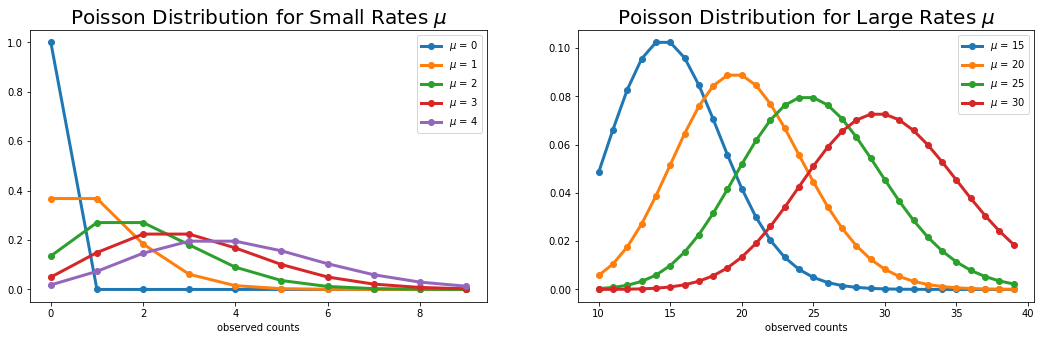

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1)

x = list(range(10))
muv = [0,1,2,3,4]
for mu in muv:
    y = poisson(mu=mu).pmf(x)
    ax1.plot(x,y,linewidth=3,marker='o')
    
ax1.set_title('Poisson Distribution for Small Rates $\mu$',fontsize=20)
ax1.set_xlabel('observed counts')
ax1.legend(['$\mu$ = %s' % str(mu) for mu in muv])



ax2 = fig.add_subplot(1,2,2)

x = list(range(10,40))
muv = [15,20,25,30]
for mu in muv:
    y = poisson(mu=mu).pmf(x)
    ax2.plot(x,y,linewidth=3,marker='o')
    
ax2.set_title('Poisson Distribution for Large Rates $\mu$',fontsize=20)
ax2.set_xlabel('observed counts')
ax2.legend(['$\mu$ = %s' % str(mu) for mu in muv])

plt.savefig('img/poissonmodels01.png')

## Analogy to Least Squares Regression
To anchor intuition in familiar territory, consider least squares regression with a log-linear relationship between endogenous and exogenous variables (that is, the model assumes $log(y)=a + \mathbf{bx}$ that is beset with Gaussian noise). The familiar form for the model is:

\begin{equation}
\begin{array}{rl}
y &= a\exp{\mathbf{b \cdot x}} + \epsilon \\
&= \exp\mathbf{\beta \cdot x} + \epsilon
\end{array}
\end{equation}

Where the constant $a$ was absorbed into the coefficient vector $\mathbf{\beta}$ in the second line, and $\mathbf{x} \rightarrow [1,\mathbf{x}]$. $\epsilon$ is an error term that is assumed to have normal distribution with zero mean, i.e. $\epsilon \sim \mathscr{N}(0,\sigma)$. It's a bit unnatural, but this can be rewritten, absorbing the parameters into the random term:

\begin{equation}
y = 0 + \epsilon'
\end{equation}

With $\epsilon' \sim \mathscr{N}(\mu = \exp{\mathbf{\beta \cdot x}},\sigma)$. Now what if the fluctuations aren't normally distributed about the mean, but they are Poisson distributed about the mean? In that case, $\epsilon' \sim \mathrm{Poisson}(\mu = \exp{\mathbf{\beta \cdot x}})$. 

## Standard Implementation

Below, the model is implemented on data that exactly matches the assumptions of the model.

The identity between the mean and the variance can be seen in the residuals, which have variance $\sigma = \mu(x)$, and can therefore be rescaled to have constant variance by dividing them by $\sqrt{\mu(x)}$.

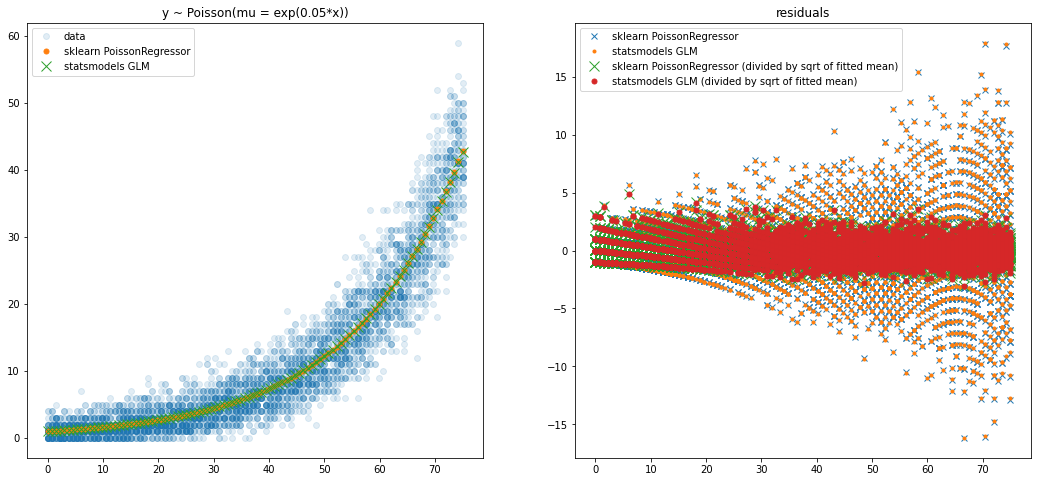

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import PoissonRegressor


"""
Generate Data; Linear Case
"""
beta_true = 0.05

def get_samples(x,n_samples):
    mu = np.exp(beta_true*x)
    return np.random.poisson(lam=mu,size=n_samples)#np.random.randint(low=0,high=n_samples,size=1))

xv = np.linspace(0,75,100)
data = []
for x in xv: 
    data += [[x,y] for y in get_samples(x,50)]
data = np.array(data)


"""
Poisson Regressor
"""
reg1 = PoissonRegressor().fit(data[:,0].reshape(-1,1),data[:,1])
reg2 = sm.GLM(exog=data[:,0],endog=data[:,1],family=sm.families.Poisson()).fit()



fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data[:,0],data[:,1],alpha=0.125,marker='o',linestyle='')
ax1.plot(xv,reg1.predict(xv.reshape(-1,1)),'.',markersize=10)
ax1.plot(xv,reg2.predict(xv.reshape(-1,1)),'x',markersize=10)
ax1.legend(['data','sklearn PoissonRegressor','statsmodels GLM'])
ax1.set_title('y ~ Poisson(mu = exp(0.05*x))')


res1 = data[:,1]-reg1.predict(data[:,0].reshape(-1,1))
res2 = data[:,1]-reg2.predict(data[:,0].reshape(-1,1))
res1sc = res1/np.sqrt(reg1.predict(data[:,0].reshape(-1,1)))
res2sc = res2/np.sqrt(reg2.predict(data[:,0].reshape(-1,1))) 
ax2.plot(data[:,0],res1,'x')
ax2.plot(data[:,0],res2,'.')
ax2.plot(data[:,0],res1sc,'x',markersize=10)
ax2.plot(data[:,0],res2sc,'.',markersize=10)
ax2.legend(['sklearn PoissonRegressor','statsmodels GLM','sklearn PoissonRegressor (divided by sqrt of fitted mean)','statsmodels GLM (divided by sqrt of fitted mean)'])
ax2.set_title('residuals')

plt.savefig('img/poissonmodels02.png')

# Nonlinear Model

In general, there is no problem with assuming Poisson noise for other types of models. The function $\mu = f(x)$ can be replaced with some machine learning model, and the loss function modified appropriately.

XGBoost supports poisson loss. Empirically, it seems that Poisson loss performs worse in the regime where the model is underfitting, and slightly better in the regime where the model is overfitting. The difference is especially pronounced in the Poisson deviance and for sparse data.

/Users/balthasar/.virtualenvs/stats/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Text(0, 0.5, 'error')

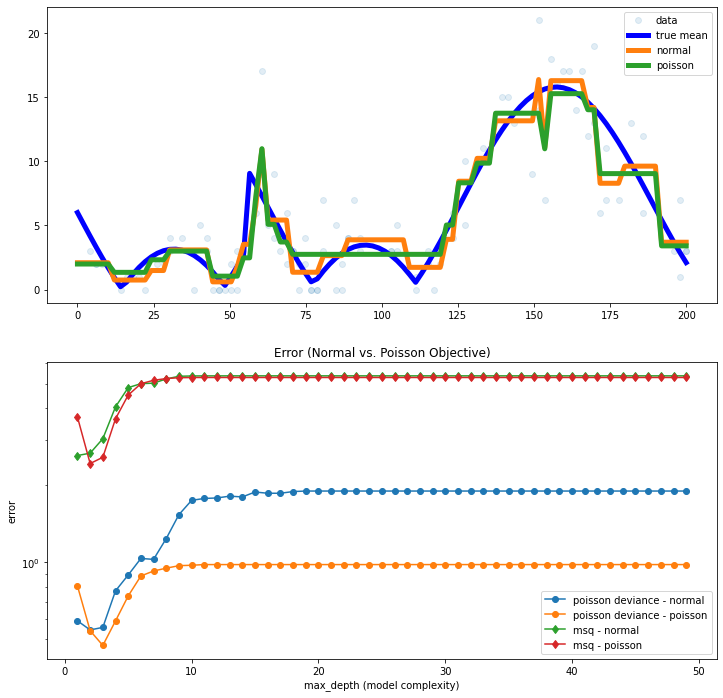

In [3]:
import xgboost as xgb
from sklearn.metrics import mean_poisson_deviance,mean_squared_error

"""
Generate Data; Nonlinear
"""

def mu(x):
    return np.abs(9*np.sin(0.05*x)+6*np.sign(x-55)) + 0.005*x 

def get_samples(x,n_samples):
    m = mu(x)
    return np.random.poisson(lam=m,size=n_samples)#np.random.randint(low=0,high=n_samples,size=1))

xv = np.linspace(0,200,100)
data = []
for x in xv: 
    data += [[x,y] for y in get_samples(x,np.random.randint(low=0,high=3))]
data = np.array(data)

x = data[:,0].reshape(len(data),1)
y = data[:,1].reshape(len(data),1)
dtrain = xgb.DMatrix(x, label=y)



"""
Train XGBoost Models 
"""

max_depth = 2
eta = 1
num_round = 10

# Poisson Loss
param = {'max_depth': max_depth, 'eta': eta, 'objective': "count:poisson"}
bst = xgb.train(param, dtrain, num_round)

y_pred_poisson = bst.predict(xgb.DMatrix(xv.reshape(len(xv),1)))

# Normal Loss
param = {'max_depth': max_depth, 'eta': eta,'objective': "reg:squarederror"}
bst = xgb.train(param, dtrain, num_round)

y_pred_normal = bst.predict(xgb.DMatrix(xv.reshape(len(xv),1)))



"""
Plotting
"""

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(data[:,0],data[:,1],'o',alpha=0.125)
ax1.plot(xv,mu(xv),linewidth=5,color='blue')

ax1.plot(xv,y_pred_normal,linewidth=5)
ax1.plot(xv,y_pred_poisson,linewidth=5)

ax1.legend(['data','true mean','normal','poisson'])


"""
Checking relative error of poisson loss and normal loss
"""

poisson_deviance = []
msq = []

max_depths = range(1,50)

for max_depth in max_depths:
    # Poisson Loss
    param = {'max_depth': max_depth, 'eta': eta, 'objective': "count:poisson"}
    bst = xgb.train(param, dtrain, num_round)

    y_pred_poisson = bst.predict(xgb.DMatrix(xv.reshape(len(xv),1)))

    # Normal Loss
    param = {'max_depth': max_depth, 'eta': eta,'objective': "reg:squarederror"}
    bst = xgb.train(param, dtrain, num_round)

    y_pred_normal = bst.predict(xgb.DMatrix(xv.reshape(len(xv),1)))

    poisson_deviance.append(
        (mean_poisson_deviance(mu(xv),np.abs(y_pred_normal)),
         mean_poisson_deviance(mu(xv),y_pred_poisson))
    )

    msq.append(
        (mean_squared_error(mu(xv),np.abs(y_pred_normal)),
         mean_squared_error(mu(xv),y_pred_poisson))
    )

poisson_deviance = np.array(poisson_deviance)
msq = np.array(msq)
   
    
"""
Plotting
"""

ax2 = fig.add_subplot(2,1,2)

ax2.semilogy(max_depths,poisson_deviance[:,0],'o-')
ax2.semilogy(max_depths,poisson_deviance[:,1],'o-')

ax2.semilogy(max_depths,msq[:,0],'d-')
ax2.semilogy(max_depths,msq[:,1],'d-')

ax2.legend('poisson deviance - normal,poisson deviance - poisson,msq - normal,msq - poisson'.split(','))
ax2.set_title('Error (Normal vs. Poisson Objective)')
ax2.set_xlabel('max_depth (model complexity)')
ax2.set_ylabel('error')